CS233 HW3 \
Problem 1 

In [1]:
# todo (a)
import numpy as np
import skimage
from skimage import exposure
import skimage.io
import skimage.transform
import skimage.feature
import os
import matplotlib.pyplot as plt

from mrf import mrf


In [2]:
# ---Visualization Utilities--- #
#
# ----------------------------- #

def mat_show(matrix):
	"""
	Visualize matrix
	"""
	plt.matshow(matrix)
	plt.colorbar()
	plt.show()


def save_hog_image(hog_image, title, output_path):
	"""
	save the visualization of the hog feature
	"""
	fig, ax = plt.subplots(1, 1, figsize=(4, 4))

	# Rescale histogram for better display
	hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

	ax.axis('off')
	ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
	ax.set_title(title)
	plt.savefig(output_path)


# ----------------------------- #

# directory of rendered views of each shape
rendering_dir = '../data_p1/100chairs_rendering'
# number of chairs in our dataset
num_shapes = 100
# number of rendered views for each shape
num_views = 16

output_path = '../outputs_p1'
os.makedirs(output_path, exist_ok=True)



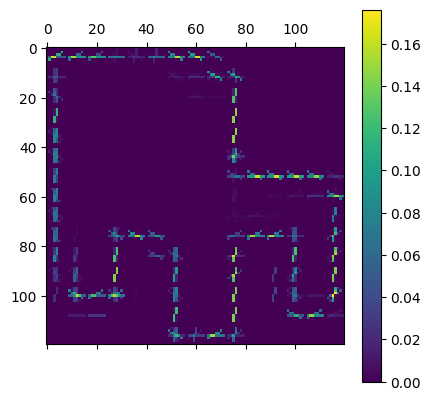

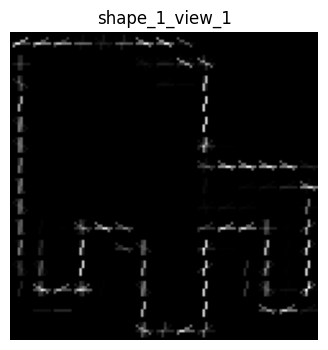

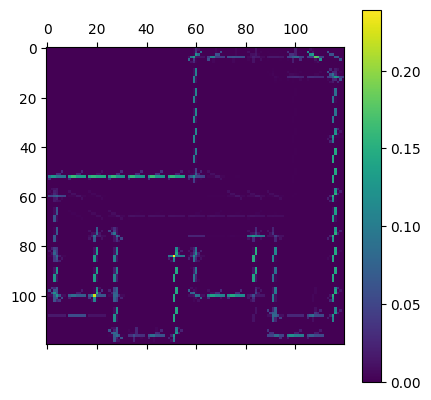

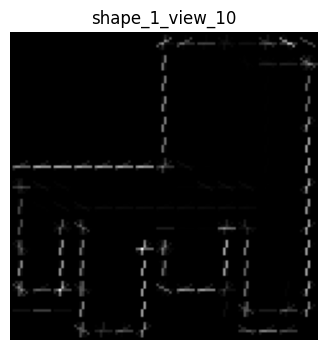

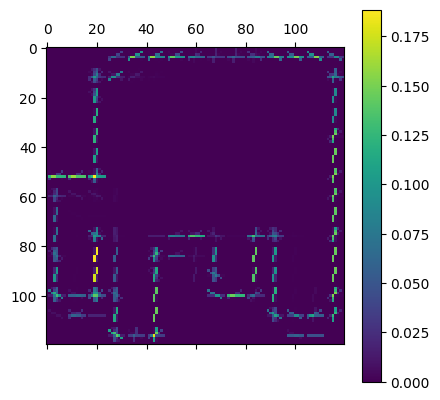

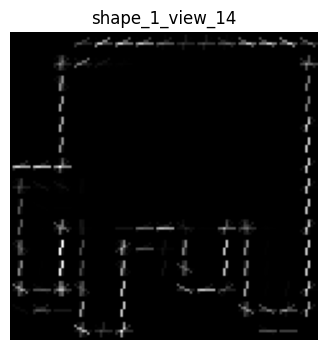

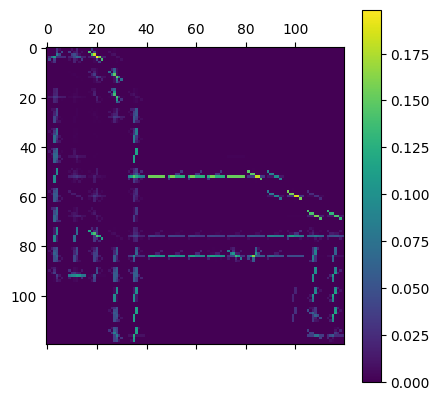

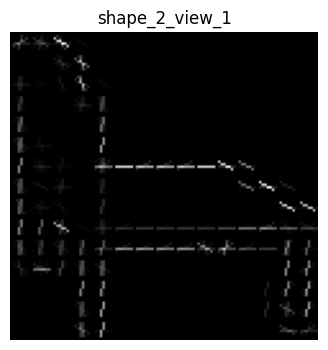

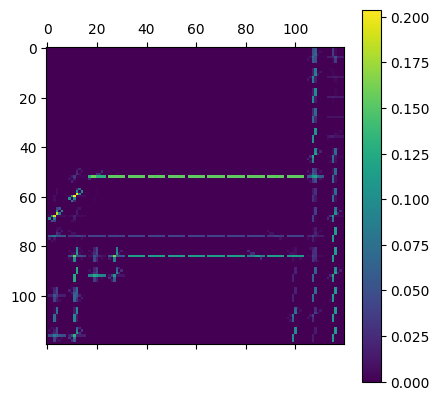

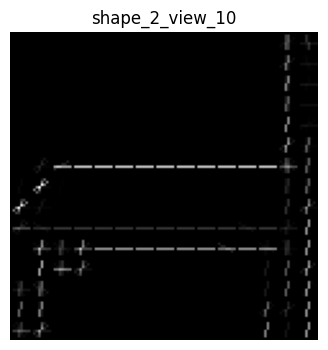

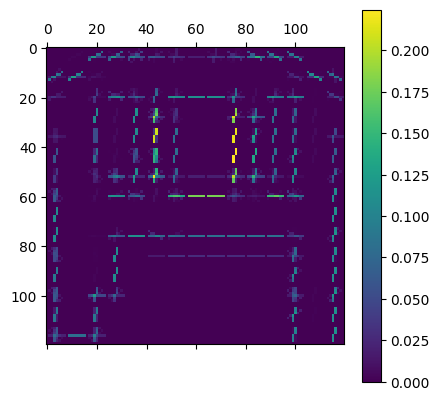

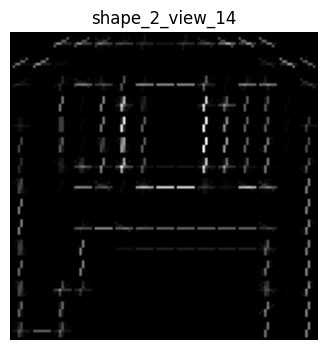

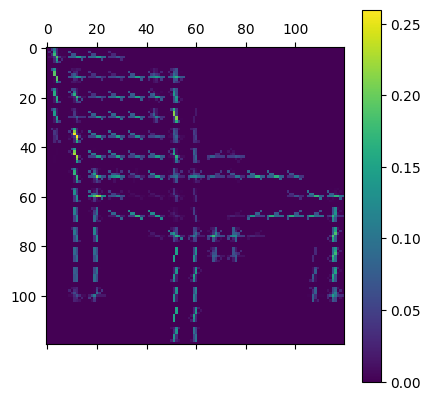

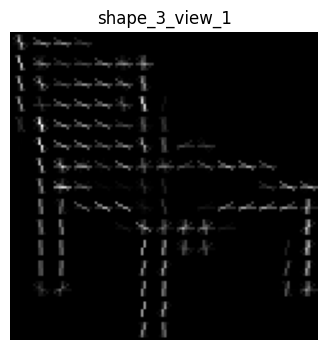

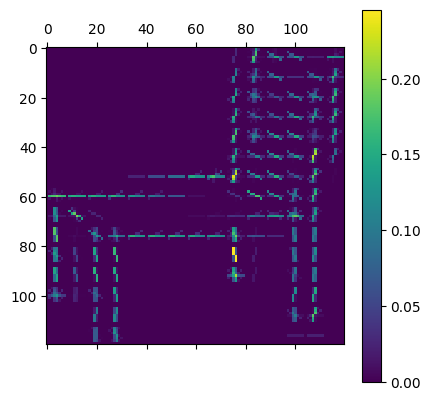

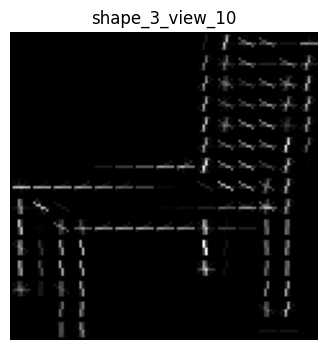

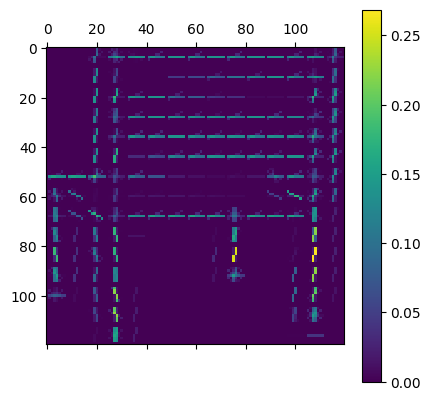

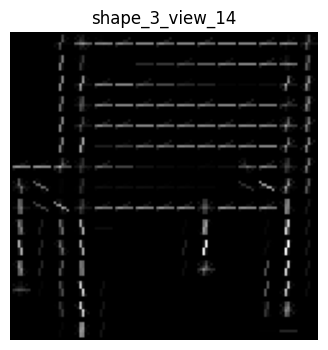

In [3]:
##
# P1(a): extract HoG features of each input image
#        to represent each shape by V x H dim feature.

def hog_extraction(image):
	"""
		Input: 
			image: H x W 
		Output:
			feature: HoG feature
			hog_image: HoG feature visualization

	"""
	# ------ Your code here ------- #
	# TODO resize the image to 120x120,
	#  extract HoG feature for the image,
	#  return the feature vector and a visualization of the feature
	# You may use skimage.transform.resize and skimage.feature.hog
	# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html
	# ----------------------------- #
	image = skimage.transform.resize(image, (120, 120))
	feature, hog_image = skimage.feature.hog(image, visualize=True)
	return feature, hog_image


# ------ Your code here ------- #
# TODO: implement function hog_extraction
# TODO: compute the representation of each shape 
#       by computing the HoG feature of each view
# You may use skimage.io.imread for loading images
# ----------------------------- #
shape_features = []
for shape_idx in range(num_shapes):
	shape_hog = []
	for view_idx in range(num_views):
		image_path = os.path.join(rendering_dir, f'{(shape_idx+1):03d}_{view_idx:01d}.png')
		image = skimage.io.imread(image_path, as_gray=True)
		feature, hog_image = hog_extraction(image)
		shape_hog.append(feature)
		if (shape_idx <= 2) and (view_idx in [1, 10, 14]): # favorite views: 1, 10, 14
			mat_show(hog_image)
			save_hog_image(hog_image, f'shape_{shape_idx+1}_view_{view_idx}', 
				  os.path.join(output_path, f'shape_{shape_idx+1}_view_{view_idx}.png'))
	shape_features.append(np.stack(shape_hog, axis=0))

# ----------------------------- #

In [4]:
shape_features[0].shape

(16, 13689)

In [5]:
##
# P1(b): compute pairwise dissimilarity matrix between shapes

# ------ Your code here ------- #
# TODO: implement function pairwise_dissimilarity
# TODO: compute the dissimilarity matrix between each pair of shapes
# ----------------------------- #


def pairwise_dissimilarity(feat1, feat2):
	"""
	Compute pairwise dissimilarity matrix between two shapes.
	Input:
	 - feat1, feat2: VxH shape feature. Each row corresponds 
	to the HoG feature of an image view.    
	Output:                                                   
	  - D : VxV dissimilarity matrix                          
	"""
	# ------ Your code here ------- #
	# ----------------------------- #
	D = np.zeros((feat1.shape[0], feat2.shape[0]))
	for i in range(feat1.shape[0]):
		for j in range(feat2.shape[0]):
			D[i, j] = np.linalg.norm(feat1[i] - feat2[j])
	return D

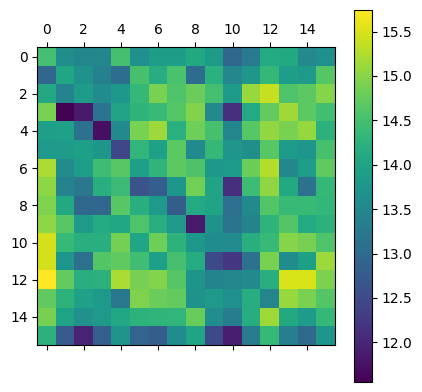

Pair of views with minimum dissimilarity: 3, 1
Pair of views with maximum dissimilarity: 12, 0


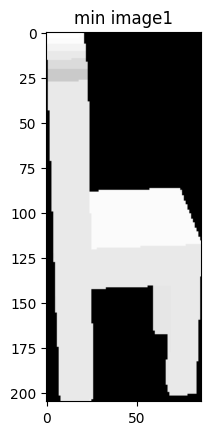

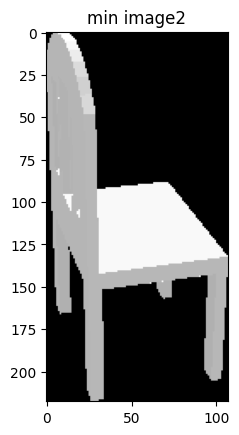

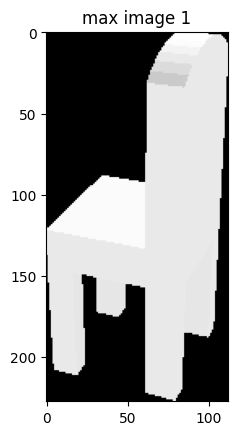

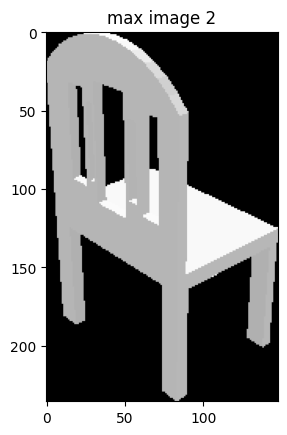

In [6]:
# Compute the pairwise dissimilarity matrix between two shapes
feat1 = shape_features[0]
feat2 = shape_features[1]
D = pairwise_dissimilarity(feat1, feat2)
# Visualize the dissimilarity matrix
mat_show(D)
# Find index corresponding to the minimum value in the dissimilarity matrix
min_i, min_j = np.unravel_index(np.argmin(D), D.shape)
print(f'Pair of views with minimum dissimilarity: {min_i}, {min_j}')
# Find index corresponding to the maximum value in the dissimilarity matrix
max_i, max_j = np.unravel_index(np.argmax(D), D.shape)
print(f'Pair of views with maximum dissimilarity: {max_i}, {max_j}')
# Visualize the pair of views with minimum dissimilarity
image_min_i = os.path.join(rendering_dir, f'{(0+1):03d}_{min_i:01d}.png')
image_min_j = os.path.join(rendering_dir, f'{(1+1):03d}_{min_j:01d}.png')
image1 = skimage.io.imread(image_min_i, as_gray=True)
image2 = skimage.io.imread(image_min_j, as_gray=True)
# plot image1
plt.imshow(image1, cmap='gray')
plt.title('min image1')
plt.show()
plt.imshow(image2, cmap='gray')
plt.title('min image2')
plt.show()

image_max_i = os.path.join(rendering_dir, f'{(0+1):03d}_{max_i:01d}.png')
image_max_j = os.path.join(rendering_dir, f'{(1+1):03d}_{max_j:01d}.png')
image1 = skimage.io.imread(image_max_i, as_gray=True)
image2 = skimage.io.imread(image_max_j, as_gray=True)

plt.imshow(image1, cmap='gray')
plt.title("max image 1")
plt.show()
plt.imshow(image2, cmap='gray')
plt.title("max image 2")
plt.show()

In [10]:
# ----------------------------- #
##
# P1(c): joint shape alignment by MRF

# P1(c).1: If unary is ignored, the objective is to find view allocation that maximize the sum of all pairwise affinities between different shapes, which is equivalent to find view for all shape that matches the best with the other shape.

# ------ Your code here ------- #
# TODO: build W_ij matrix that holds affinities for all pairs of shapes
sigma = 15
W = []
for i in range(num_shapes):
    W_i = []
    for j in range(num_shapes):
        D = pairwise_dissimilarity(shape_features[i], shape_features[j])
        W.append(np.exp(-D/sigma))

# TODO: build unary vector U
# Select set max element in each view as 1 and the rest as 0
U = np.random.rand(num_shapes, num_views)
D = (U == U.max(axis=1)[:, None]).astype(int)
D = D.flatten() # N x V
# A block matrix
M = np.zeros((num_shapes * num_views, num_shapes * num_views))
for i in range(num_shapes):
    for j in range(num_shapes):
        M[i*num_views:(i+1)*num_views, j*num_views:(j+1)*num_views] = W[i*num_shapes+j]
node_indices = np.arange(num_shapes).repeat(num_views)
label_indices = np.tile(np.arange(num_views),num_shapes)
# TODO: call MRF solver from mrf.py to jointly align shapes
sol, score, labels = mrf(M, D, 
                        node_indices=node_indices, 
                        label_indices=label_indices, 
                        iterEigen=30, 
                        iterClimb=200)


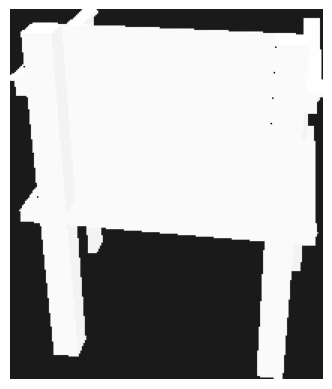

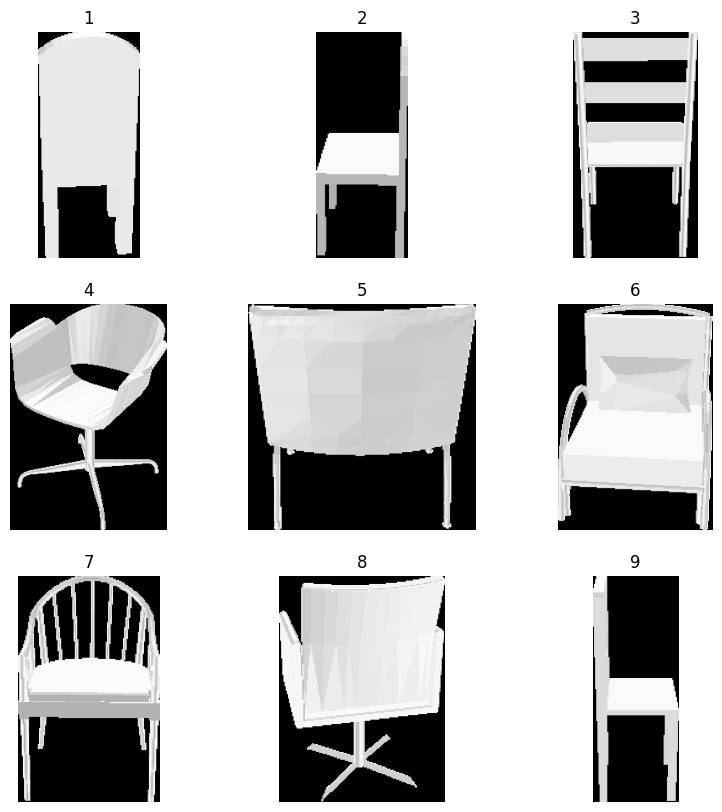

In [11]:
# ----------------------------- #
# Select the optimal view for each shape
if not os.path.exists("aligned"):
    os.mkdir("aligned")
first_9 = []
for i,view in enumerate(labels):
    image = skimage.io.imread(os.path.join(rendering_dir, f'{(i+1):03d}_{view:01d}.png'), as_gray=True)
    if i < 9:
        first_9.append(image)
    # Save in a folder
    # Save using plt
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.savefig(f"aligned/{i+1}.png")

# Visualize first 9 aligned view in a single figure
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(first_9[i*3+j], cmap='gray')
        ax[i, j].axis('off')
        # Add title as id
        ax[i, j].set_title(f'{i*3+j+1}')
plt.show()